/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/baater/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:17<00:00, 1.23MB/s]


开始加载图像...
图像加载成功。


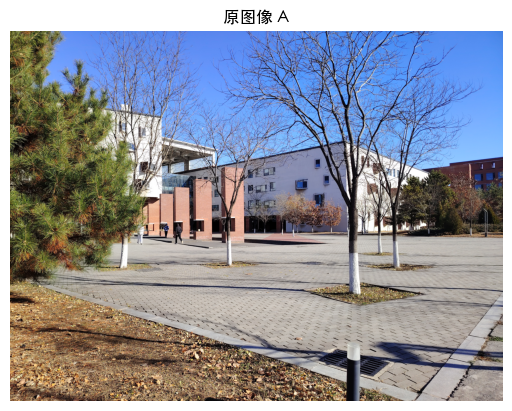

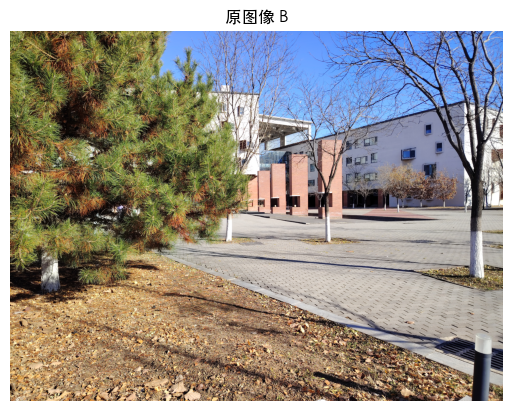

正在处理 图像 A 的特征点检测和描述...
图像 A 检测到 500 个关键点，开始提取特征...
图像 A 有效的关键点数量：482


提取 图像 A 特征: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


图像 A 特征提取完成，特征数量：(482, 62720)
正在处理 图像 B 的特征点检测和描述...
图像 B 检测到 500 个关键点，开始提取特征...
图像 B 有效的关键点数量：495


提取 图像 B 特征: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


图像 B 特征提取完成，特征数量：(495, 62720)
正在绘制 图像 A 的特征图 ...


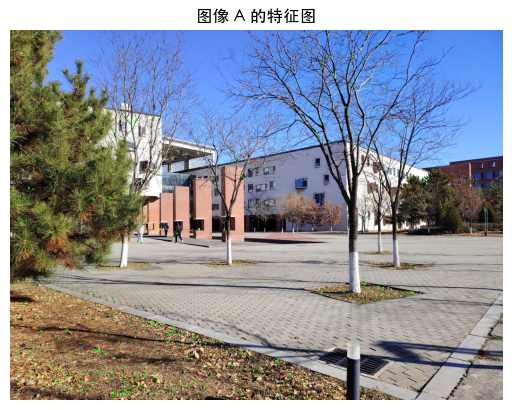

正在绘制 图像 B 的特征图 ...


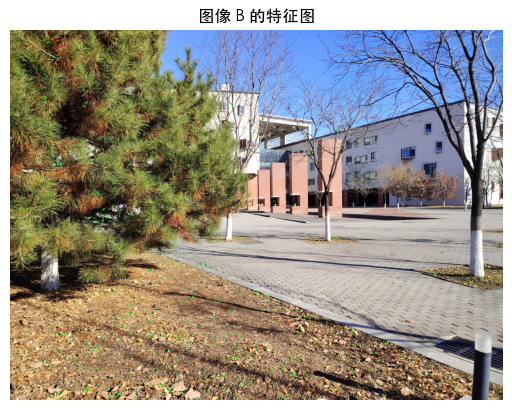

开始匹配特征点...
匹配完成，找到 26 对好的匹配点。
正在绘制匹配结果...


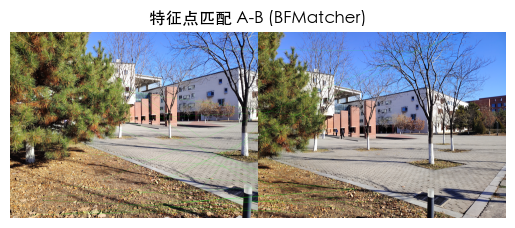

开始计算单应性矩阵并拼接图像...
内点数量：22，外点数量：4.0


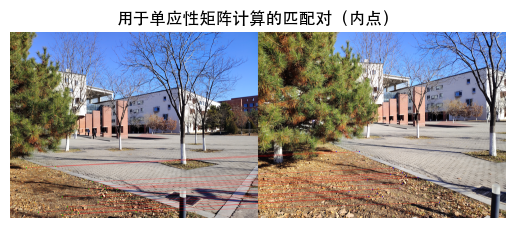

图像拼接完成。


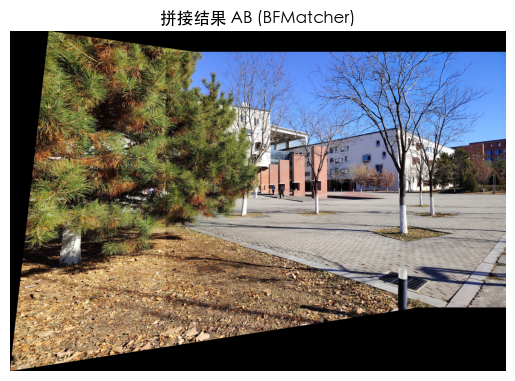

拼接结果已保存至: ./output_BFMatcher_EfficientNet/stitched_3_4.jpg


In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torchvision import models
from tqdm import tqdm  # 进度条库

# 设置全局字体

plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============================
# 配置参数
# ============================
# imageA_path = "../datasets/yongzhou/DSC03213.JPG"  # 图像 A 的路径
# imageB_path = "../datasets/yongzhou/DSC03215.JPG"  # 图像 B 的路径

imageA_path = "../datasets/new_data/3.jpg"  # 图像 A 的路径
imageB_path = "../datasets/new_data/4.jpg"  # 图像 B 的路径

# 匹配参数
distance_ratio = 0.9       # Lowe 的比率测试中的距离比
ransac_threshold = 5        # RANSAC 阈值
min_matches_required = 4    # 计算单应性矩阵所需的最小匹配点数量
patch_size = 32             # 提取图像块的大小
max_keypoints = 500         # 每幅图像中最多使用的关键点数量

# ============================
# 加载预训练的 EfficientNet-B0 模型
# ============================
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
efficientnet_features = efficientnet_b0.features  # 提取特征部分
efficientnet_classifier = torch.nn.Sequential(*list(efficientnet_b0.classifier.children())[:-1])  # 去掉最后的分类层
model = torch.nn.Sequential(
    efficientnet_features,
    torch.nn.AdaptiveAvgPool2d(output_size=(7, 7)),  # EfficientNet 的特征图需要经过自适应池化
    torch.nn.Flatten(),
    efficientnet_classifier
)
model.eval()  # 设置为评估模式

# 设备配置
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 选择设备：使用 MPS（Metal Performance Shaders）在 Apple Silicon 上进行计算，或者回退到 CPU
device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')

model.to(device)

# 预处理函数，将图像转换为符合 EfficientNet 输入要求的格式
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # EfficientNet 的标准化参数
                         std=[0.229, 0.224, 0.225]),
])

def show_image(image, title="Image"):
    """
    显示图像的辅助函数，支持彩色和灰度图显示
    """
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image, image_name="Image"):
    """
    使用 SIFT 进行关键点检测，并使用 EfficientNet 提取特征描述符
    """
    print(f"正在处理 {image_name} 的特征点检测和描述...")

    # -------------------------------
    # 图像预处理
    # -------------------------------
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 应用高斯滤波，减少噪声
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # 应用自适应直方图均衡化，增强对比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # show_image(gray, f"{image_name} 的预处理结果")

    # 使用 SIFT 检测关键点
    sift = cv2.SIFT_create(nfeatures=max_keypoints)
    keypoints = sift.detect(gray, None)
    keypoints = sorted(keypoints, key=lambda x: -x.response)[:max_keypoints]  # 取响应值最大的关键点

    print(f"{image_name} 检测到 {len(keypoints)} 个关键点，开始提取特征...")

    # 提取特征描述符
    descriptors = []
    valid_keypoints = []
    patches = []

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # 提取图像块
        x1 = x - patch_size // 2
        y1 = y - patch_size // 2
        x2 = x + patch_size // 2
        y2 = y + patch_size // 2

        # 检查边界
        if x1 >= 0 and y1 >= 0 and x2 <= image.shape[1] and y2 <= image.shape[0]:
            patch = image[y1:y2, x1:x2]
            patches.append(patch)
            valid_keypoints.append(kp)
        else:
            continue

    print(f"{image_name} 有效的关键点数量：{len(valid_keypoints)}")

    # 批量处理图像块，提取特征
    batch_size = 64
    for i in tqdm(range(0, len(patches), batch_size), desc=f"提取 {image_name} 特征"):
        batch_patches = patches[i:i+batch_size]
        batch_tensors = [transform(patch) for patch in batch_patches]
        batch_tensors = torch.stack(batch_tensors).to(device)
        with torch.no_grad():
            batch_features = model(batch_tensors)
            descriptors.extend(batch_features.cpu().numpy())

    descriptors = np.array(descriptors)
    print(f"{image_name} 特征提取完成，特征数量：{descriptors.shape}")
    return valid_keypoints, descriptors

def match_keypoints(desA, desB):
    """
    使用 BFMatcher 进行特征匹配，并应用 Lowe 的比率测试筛选优秀匹配点
    """
    print("开始匹配特征点...")
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    raw_matches = matcher.knnMatch(desA, desB, k=2)

    # 应用 Lowe 的比率测试
    good_matches = []
    matches = []
    for m, n in raw_matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))

    print(f"匹配完成，找到 {len(good_matches)} 对好的匹配点。")
    return good_matches, matches

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    绘制两个图像之间的匹配结果
    """
    print("正在绘制匹配结果...")
    # 自定义绘图参数
    draw_params = dict(
        matchColor=(0, 255, 0),       # 匹配的线为绿色
        singlePointColor=(255, 0, 0), # 未匹配的点为蓝色
        matchesMask=None,             # 不使用掩码
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA, good_matches, None, **draw_params)
    return vis

def stitch_images(center_image, align_image, center_kps, align_kps, matches):
    """
    利用匹配点计算单应性矩阵并进行图像拼接
    """
    print("开始计算单应性矩阵并拼接图像...")
    if len(matches) > min_matches_required:
        pts_center = np.float32([center_kps[i].pt for (i, _) in matches])
        pts_align = np.float32([align_kps[i].pt for (_, i) in matches])

        # 使用 RANSAC 计算单应性矩阵
        H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        # 提取内点
        inlier_pts_center = pts_center[status.ravel() == 1]
        inlier_pts_align = pts_align[status.ravel() == 1]

        print(f"内点数量：{np.sum(status)}，外点数量：{len(status) - np.sum(status)}")

        # 创建合并的图像用于显示
        combined_image = np.hstack((center_image, align_image))
        offset = center_image.shape[1]

        # 绘制匹配对，增强可见性
        for pt_center, pt_align in zip(inlier_pts_center, inlier_pts_align):
            pt_center = (int(pt_center[0]), int(pt_center[1]))
            pt_align = (int(pt_align[0] + offset), int(pt_align[1]))
            cv2.circle(combined_image, pt_center, 8, (0, 255, 0), -1)  # 中心图像的点（绿色）
            cv2.circle(combined_image, pt_align, 8, (255, 0, 0), -1)   # 对齐图像的点（蓝色）
            cv2.line(combined_image, pt_center, pt_align, (0, 0, 255), 2)  # 连接线（红色，粗线）

        show_image(combined_image, "用于单应性矩阵计算的匹配对（内点）")

        # 拼接图像
        height_center, width_center = center_image.shape[:2]
        height_align, width_align = align_image.shape[:2]
        # 计算输出图像尺寸
        corners_center = np.float32([[0,0], [0,height_center], [width_center,height_center], [width_center,0]]).reshape(-1,1,2)
        corners_align = np.float32([[0,0], [0,height_align], [width_align,height_align], [width_align,0]]).reshape(-1,1,2)
        corners_align_transformed = cv2.perspectiveTransform(corners_align, H)
        all_corners = np.concatenate((corners_center, corners_align_transformed), axis=0)
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())
        translation_dist = [-x_min, -y_min]

        H_translation = np.array([[1, 0, translation_dist[0]],
                                  [0, 1, translation_dist[1]],
                                  [0, 0, 1]])

        result = cv2.warpPerspective(align_image, H_translation @ H, (x_max - x_min, y_max - y_min))
        result[translation_dist[1]:height_center+translation_dist[1], translation_dist[0]:width_center+translation_dist[0]] = center_image

        print("图像拼接完成。")
        return result
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None

def show_keypoints(image, keypoints, title="Keypoints"):
    """
    显示特征点，并使用较大的圆圈标注特征点位置
    """
    print(f"正在绘制 {title} ...")
    # 创建一个空白图像用于绘制
    image_with_keypoints = image.copy()
    # 增强特征点的可见性
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 6, (0, 255, 0), 2)  # 绿色圆圈，较大
    show_image(image_with_keypoints, title)

# 加载图像并执行拼接
print("开始加载图像...")
imageA = cv2.imread(imageA_path)
imageB = cv2.imread(imageB_path)

# 确保图像加载成功
if imageA is None or imageB is None:
    print("Error: Could not load one or both images.")
else:
    print("图像加载成功。")
    show_image(imageA, '原图像 A')
    show_image(imageB, '原图像 B')

    # 提取并显示特征点和描述符
    kpsA, desA = detectAndDescribe(imageA, "图像 A")
    kpsB, desB = detectAndDescribe(imageB, "图像 B")

    # 显示特征点
    show_keypoints(imageA, kpsA, '图像 A 的特征图')
    show_keypoints(imageB, kpsB, '图像 B 的特征图')

    # 使用 BFMatcher 匹配特征
    good_matches_AB, matches_AB = match_keypoints(desA, desB)

    # 显示匹配结果
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    if vis_AB is not None:
        show_image(vis_AB, '特征点匹配 A-B (BFMatcher)')

    # 图像拼接
    stitchedAB = stitch_images(imageA, imageB, kpsA, kpsB, matches_AB)
    if stitchedAB is not None:
        show_image(stitchedAB, '拼接结果 AB (BFMatcher)')

        # 保存拼接结果
        baseA = os.path.basename(imageA_path)[-7:-4]
        baseB = os.path.basename(imageB_path)[-7:-4]
        output_dir = './output_BFMatcher_EfficientNet'
        output_filename = f"{output_dir}/stitched_{baseA}_{baseB}.jpg"
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(output_filename, stitchedAB)
        print(f"拼接结果已保存至: {output_filename}")
    else:
        print("由于匹配点不足，拼接失败。")
